### Tensor-based Cahn-Hilliard

In [15]:
import sys

import torch as tp
import pyro
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm as cm
plt.style.use("ggplot")

In [2]:
sys.path.insert(1, '..\\src\\cahnhilliard.py')
 ## Access local script
from demixing_2d import *

In [3]:
LogNormal = pyro.distributions.LogNormal
Normal    = pyro.distributions.Normal

In [4]:
GLOBAL_DEVICE = tp.device('cpu')
CUDA_DEVICE   = tp.device('cuda' if tp.cuda.is_available() else 'cpu')

In [5]:
theta = {
    'a': LogNormal(-11.86, 0.1),
    'b': Normal(1.2e-4, 1e-6),
    'k': LogNormal(-0.35, 0.01)
}

def sample_priors(theta, device=GLOBAL_DEVICE):
    samples = {}
    for k,v in theta.items():
        samples[k] = pyro.sample(k, v).to(device)
    return samples

In [6]:
params = Variables(theta=sample_priors(theta))

In [7]:
def run(params=None, nt=9, max_iter=1e4, seed=None, device=GLOBAL_DEVICE):
    if params is None:
        params = Variables(
            theta = sample_priors(
                 {
                    'a': LogNormal(-11.86, 0.1),
                    'b': Normal(1.2e-4, 1e-6),
                    'k': LogNormal(-0.35, 0.01)
                },
                device=device
            )
        )
    # Construct Cahn Hilliard simulation model
    model = CahnHilliard(params=params, dim=2, seed=seed, device=device)
    
    ts = np.linspace(0, max_iter, nt).astype(np.int)
    
    q, S0 = model.scattering()
    S = tp.zeros(S0.shape[0], nt)
    S[:,0] = S0
    
    t = 1
    for k in range(int(max_iter)):
        model.iterate()
        if (k+1) in ts:
            _, St = model.scattering()
            S[:,t] = St
            t+=1
    return ts, q, S

In [8]:
ts, q, S = run()

In [31]:
def plot_sample(ts, q, S, yscale='log', cname='Blues'):
    cmap = cm.get_cmap(cname)
    cmap = [cmap(z) for z in np.linspace(0, 1, len(ts))]
    
    _, ax = plt.subplots(1,1,figsize=(14,6))
    for i,t in enumerate(ts):
        ax.plot(q, S[:,i], '-', color=cmap[i])
    ax.set_yscale(yscale)
    ax.legend(labels=[str(t) for t in ts])

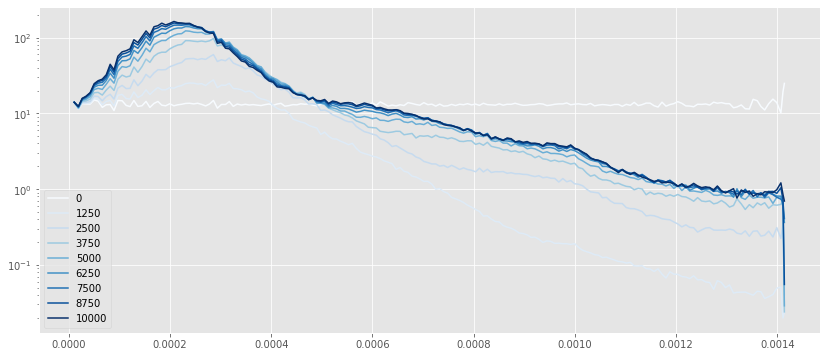

In [32]:
plot_sample(ts, q, S)